# Running Experiments

You can use the Azure Machine Learning SDK to run code experiments that log metrics and generate outputs. This is at the core of most machine learning operations in Azure Machine Learning.

## Connect to Your Workspace

The first thing you need to do is to connect to your workspace using the Azure ML SDK.

> **Note**: If the authenticated session with your Azure subscription has expired since you completed the previous exercise, you'll be prompted to reauthenticate.

In [1]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.13.0 to work with BSM_MLWorkspace3


## Run an Experiment

One of the most fundamentals tasks that data scientists need to perform is to create and run experiments that process and analyze data. In this exercise, you'll learn how to use an Azure ML *experiment* to run Python code and record values extracted from data. In this case, you'll use a simple dataset that contains details of patients that have been tested for diabetes. You'll run an experiment to explore the data, extracting statistics, visualizations, and data samples. Most of the code you'll use is fairly generic Python, such as you might run in any data exploration process. However, with the addition of a few lines, the code uses an Azure ML *experiment* to log details of the run.

Starting experiment: diabetes-experiment
Analyzing 10000 rows of data


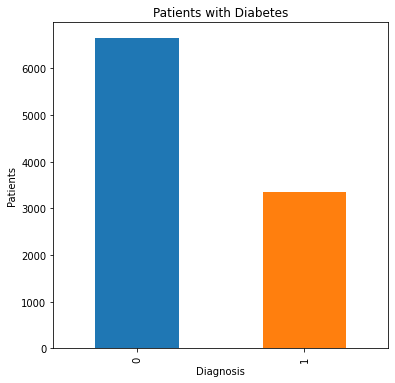

In [2]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace = ws, name = "diabetes-experiment")

# Start logging data from the experiment
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# load the data from a local file
data = pd.read_csv('data/diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])
        
# Save a sample of the data and upload it to the experiment output
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name = 'outputs/sample.csv', path_or_stream = './sample.csv')

# Complete the run
run.complete()

## View Experiment Results

After the experiment has been finished, you can use the **run** object to get information about the run and its outputs:

In [3]:
import json

# Get run details
details = run.get_details()
print(details)

# Get logged metrics
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

# Get output files
files = run.get_file_names()
print(json.dumps(files, indent=2))

{'runId': '2c3aa625-36b1-486a-94f9-e85b0d351a47', 'target': 'local', 'status': 'Completed', 'startTimeUtc': '2020-09-01T09:46:28.492524Z', 'endTimeUtc': '2020-09-01T09:46:43.136105Z', 'properties': {'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/DP100', 'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/DP100', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'b3ab0f6abbc766abee8a6cb1e300cd21f80fef96', 'mlflow.source.git.commit': 'b3ab0f6abbc766abee8a6cb1e300cd21f80fef96', 'azureml.git.dirty': 'False', 'ContentSnapshotId': '22e36606-08ae-4ed2-b529-0acaca0d32cf'}, 'inputDatasets': [], 'outputDatasets': [], 'logFiles': {}}
{
  "observations": 10000,
  "label distribution": "aml://artifactId/ExperimentRun/dcid.2c3aa625-36b1-486a-94f9-e85b0d351a47/label distribution_1598953596.png",
  "pregnancy categories": [
    0,
    8,
    7,
    9,
    1,
    3,
    5,
    2,
    6,
    11,
    4,
    13,
    10,
    12,


In Jupyter Notebooks, you can use the **RunDetails** widget to get a better visualization of the run details.

In [4]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Note that the **RunDetails** widget includes a link to view the run in Azure Machine Learning studio. Click this to open a new browser tab with the run details (you can also just open [Azure Machine Learning studio](https://ml.azure.com) and find the run on the **Experiments** page). When viewing the run in Azure Machine Learning studio, note the following:

- The **Details** tab contains the general properties of the experiment run.
- The **Metrics** tab enables you to select logged metrics and view them as tables or charts.
- The **Images** tab enables you to select and view any images or plots that were logged in the experiment (in this case, the *Label Distribution* plot)
- The **Child Runs** tab lists any child runs (in this experiment there are none).
- The **Outputs + Logs** tab shows the output or log files generated by the experiment.
- The **Snapshot** tab contains all files in the folder where the experiment code was run (in this case, everything in the same folder as this notebook).
- The **Explanations** tab is used to show model explanations generated by the experiment (in this case, there are none).
- The **Fairness** tab is used to visualize predictive performance disparities that help you evaluate the fairness of machine learning models (in this case, there are none).

## Run an Experiment Script

In the previous example, you ran an experiment inline in this notebook. A more flexible solution is to create a separate script for the experiment, and store it in a folder along with any other files it needs, and then use Azure ML to run the experiment based on the script in the folder.

First, let's create a folder for the experiment files, and copy the data into it:

In [5]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

Now we'll create a Python script containing the code for our experiment, and save it in the experiment folder.

> **Note**: running the following cell just *creates* the script file - it doesn't run it!

In [6]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

Writing diabetes-experiment-files/diabetes_experiment.py


This code is a simplified version of the inline code used before. However, note the following:
- It uses the `Run.get_context()` method to retrieve the experiment run context when the script is run.
- It loads the diabetes data from the folder where the script is located.
- It creates a folder named **outputs** and writes the sample file to it - this folder is automatically uploaded to the experiment run

Now you're almost ready to run the experiment. There are just a few configuration issues you need to deal with:

1. Create a *Run Configuration* that defines the Python code execution environment for the script - in this case, it will automatically create a Conda environment with some default Python packages installed.
2. Create a *Script Configuration* that identifies the Python script file to be run in the experiment, and the environment in which to run it.

> **Note**: Don't worry too much about the environment configuration for now - we'll explore it in more depth later.

The following cell sets up these configuration objects, and then submits the experiment.

In [7]:
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails

# create a new RunConfig object
experiment_run_config = RunConfiguration()

# Create a script config
src = ScriptRunConfig(source_directory=experiment_folder, 
                      script='diabetes_experiment.py',
                      run_config=experiment_run_config) 

# submit the experiment
experiment = Experiment(workspace = ws, name = 'diabetes-experiment')
run = experiment.submit(config=src)
RunDetails(run).show()
run.wait_for_completion()

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-experiment_1598953604_9341a66a',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-09-01T09:48:36.29582Z',
 'endTimeUtc': '2020-09-01T09:48:52.107081Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '21633a46-a9bb-46b6-b8eb-2454ffdb9db1',
  'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/DP100',
  'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/DP100',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'b3ab0f6abbc766abee8a6cb1e300cd21f80fef96',
  'mlflow.source.git.commit': 'b3ab0f6abbc766abee8a6cb1e300cd21f80fef96',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'scriptType': None,
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataRefer

As before, you can use the widget or the link to the experiment in [Azure Machine Learning studio](https://ml.azure.com) to view the outputs generated by the experiment, and you can also write code to retrieve the metrics and files it generated:

In [8]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/7019_azureml.log
outputs/sample.csv


## View Experiment Run History

Now that you've run the same experiment multiple times, you can view the history in [Azure Machine Learning studio](https://ml.azure.com) and explore each logged run. Or you can retrieve an experiment by name from the workspace and iterate through its runs using the SDK:

In [9]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['diabetes-experiment']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: diabetes-experiment_1598953604_9341a66a
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: 2c3aa625-36b1-486a-94f9-e85b0d351a47
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.2c3aa625-36b1-486a-94f9-e85b0d351a47/label distribution_1598953596.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.92090936056554, 44, 84, 105, 129, 192]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.80147828964082, 24, 58, 72, 85, 117]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228355, 7, 15, 31, 41, 92]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465324, 14, 39, 85, 197, 796

> **More Information**: To find out more about running experiments, see [this topic](https://docs.microsoft.com/azure/machine-learning/how-to-manage-runs) in the Azure ML documentation. For details of how to log metrics in a run, see [this topic](https://docs.microsoft.com/azure/machine-learning/how-to-track-experiments).